In [1]:
import pyjags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import *

# JAGS CODE ----------------------------------------------------
# Jags code to fit the model to the simulated data

code = '''
model {
    for (i in 1:N) {
        y[i] ~ dnorm(alpha + beta * x[i], tau)
    }
    # Priors
    alpha ~ dunif(0, 1e-2)
    beta ~ dnorm(0, 1e-2)
    tau <- 1 / sigma^2
    sigma ~ dunif(0, 10)
}
'''


# Real example ------------------------------------------------------------

# Load in the Church and White global tide gauge data
sea_level = pd.read_csv('https://raw.githubusercontent.com/andrewcparnell/tsme_course/master/data/church_and_white_global_tide_gauge.csv')
sea_level.head(n=5) # First 5 rows

,year_AD,sea_level_m,age_error,sea_level_error
0,1880.5,-0.159065,0.5,0.0242
1,1881.5,-0.153465,0.5,0.0242
2,1882.5,-0.170265,0.5,0.0230
3,1883.5,-0.164965,0.5,0.0228
4,1884.5,-0.144065,0.5,0.0222


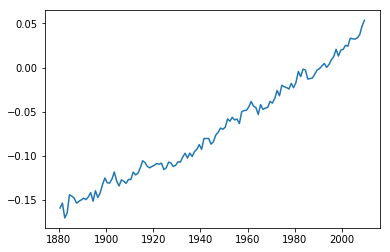

In [2]:
x = sea_level.year_AD
y = sea_level.sea_level_m
plt.plot(x,y)

In [3]:
# Set up the data
print(sea_level.shape)# Check the number of rows & columns
N = 130 # Number of rows  

model = pyjags.Model(code, data=dict(x = x, y = y, N = N), chains = 4) 

# Number of iterations to remove at start and amount of thinning
model.sample(200, vars=[], thin = 2)

# Choose the parameters to watch and iterations:
samples = model.sample(1000, vars=['alpha', 'beta', 'sigma'])

(130, 4)
adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 800 of 800, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00


In [4]:
"""
 results ----------------------------------------------------------------
"""
def summary(samples, varname, p=95):
    values = samples[varname]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in ['alpha', 'beta', 'sigma']:
    summary(samples, varname)

alpha  mean =   0.0, 95% credible interval [ 0.0  0.0]
beta   mean =  -0.0, 95% credible interval [-0.0 -0.0]
sigma  mean =   0.1, 95% credible interval [ 0.1  0.1]


/Users/alaninglis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


Mean:
Variable
alpha    0.004540
beta    -0.000038
sigma    0.060503
dtype: float64
Credible Intervals:
Variable     alpha      beta     sigma
0.05      0.000386 -0.000043  0.054446
0.95      0.009337 -0.000033  0.067361


/Users/alaninglis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.


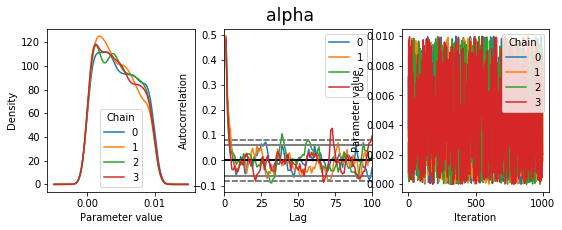

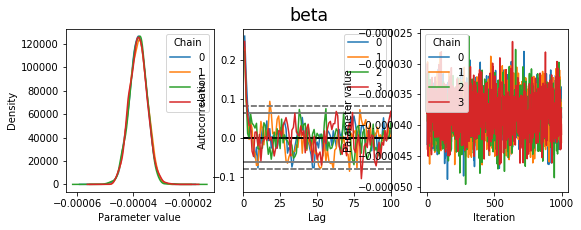

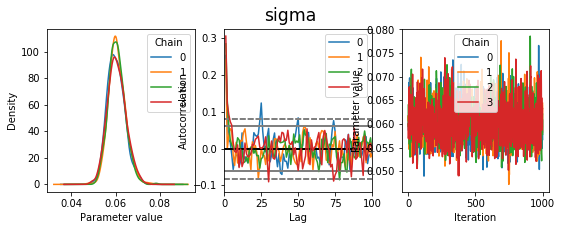

In [9]:
# Use pandas three dimensional Panel to represent the trace:
trace = pd.Panel({k: v.squeeze(0) for k, v in samples.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
# Point estimates:
print("Mean:")
print(trace.to_frame().mean()) # .to_frame converts a series to dataframe
 

# Bayesian equal-tailed 95% credible intervals:
print("Credible Intervals:")
print(trace.to_frame().quantile([0.05, 0.95]))
 

def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, fontsize='xx-large')
 
    # Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    # Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    # Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
   
 # Display diagnostic plots
for var in trace:
    plot(trace, var)

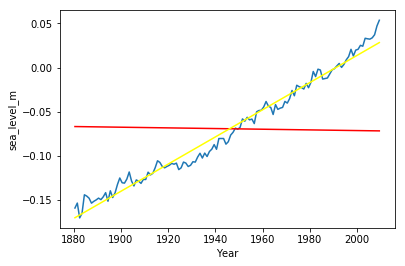

In [10]:
#The means below are the ones obtained from running pyjags:
alpha_mean = 0.004634
beta_mean = -0.000038


#However, something is not quite right here... the means should be closer to the values below (obtained from R2jags):
alpha_mean_R = -3.060865
beta_mean_R = 0.001537255

# Creating a plot:
plt.plot(x,y)
plt.ylabel('sea_level_m')
plt.xlabel('Year')
plt.plot(x, alpha_mean + beta_mean * x, c = "red")
plt.plot(x, alpha_mean_R + beta_mean_R * x, c = "yellow")
